# Ouverture du fichier
Vous pouvez cloner le fichier par contre il faudra que vous ajoutiez le fichier challenge_set.json qui est trop volumineux pour github. Celui-ci se trouve dans le dossier `spotify_million_playlist_dataset_challenge` qui lui même est donné en suivant les liens qui se trouvent dans les consignes. Une fois que vous avez mis ce fichier dans votre dossier avec le code. tout devrait run sans problème
Faites un `Ctrl+F` avec "ici" pour trouver tous les endroits où il y a un petit bug ou une optimisation à faire.  

---

## Done

Les df créés sont les suivants :

- **`df_playlists`** : contient toutes les playlists avec leurs noms et leurs paramètres.  
  La colonne `tracks` contient toutes les informations sur les musiques de la playlist, mais dans un format très « dirty ».

- **`df_tracks`** : correspond à la colonne `playlists["tracks"]`, un peu nettoyée.  
  Une même musique peut apparaître plusieurs fois.

- **`df_tracks_vectors`** : contient `track_id` et le vecteur `list_pid`de dimension 10 000 permettant de calculer la similarité entre deux musiques. Là par contre chaque musique aparait qu'une seule fois

---

## To do

- Absolument améliorer le process pour calculer les similarités en utilisant la question 3
- Rendre les data peut etre plus visuel. Par exemple pour les nom, les ecrire avec une police proportionnelle à leurs occurences
- 


In [2]:
#pip install "dask[complete]"
import pandas as pd
import numpy as np
import sys
import json
import glob
import os
import math
import dask.dataframe as dd
import matplotlib.pyplot as plt
import re
from collections import Counter


In [3]:
json_folder = os.path.join(sys.path[0], "data_json")

# cree le dossier parquet pour les albums
parquet_folder = os.path.join(sys.path[0], "data_parquet")
os.makedirs(parquet_folder, exist_ok=True)

# cree le dossier parquet pour les tracks
parquet_folder_tracks = os.path.join(sys.path[0], "data_tracks_parquet")
os.makedirs(parquet_folder_tracks, exist_ok=True)

json_files = glob.glob(os.path.join(json_folder, "*.json"))
print(f"Nombre de fichiers trouvés : {len(json_files)}")

for file in json_files:
    #print(f"Conversion de {file}...")
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)              # charge le gros dictionnaire
        playlists = data["playlists"]    # extrait la liste des playlists

    # Partie sur les albums, rempli parquet
    df = pd.json_normalize(playlists)
    base_name = os.path.basename(file).replace(".json", ".parquet")
    parquet_path = os.path.join(parquet_folder, base_name)
    df.to_parquet(parquet_path, engine="pyarrow", index=False)

    rows = []
    for pl in playlists:
        pid = pl["pid"]
        for track in pl["tracks"]:
            track["pid"] = pid   # garder l’ID de la playlist
            rows.append(track)

    df_tracks = pd.DataFrame(rows)
    
    for i in ("track", "artist", "album"):
        uri_col = i + "_uri"
        id_col = i + "_id"
        if uri_col in df_tracks.columns:
            df_tracks[id_col] = df_tracks[uri_col].str.split(":").str[-1]
            df_tracks.drop(columns=[uri_col], inplace=True)

    # Sauvegarder en Parquet
    parquet_track_path = os.path.join(parquet_folder_tracks, base_name)
    df_tracks.to_parquet(parquet_track_path, engine="pyarrow", index=False)

print("Data sur les albums")
df = dd.read_parquet(parquet_folder)
print(df.head())
print("Data sur les tracks")
df_tracks = dd.read_parquet(parquet_folder_tracks)
print(df_tracks.head())
print(df_tracks.columns)


Nombre de fichiers trouvés : 1000


You can run directly those lines id parqueets folder already exists

In [14]:
parquet_folder = os.path.join(sys.path[0], "data_parquet")
parquet_folder_tracks = os.path.join(sys.path[0], "data_tracks_parquet")
df_playlists = dd.read_parquet(parquet_folder)
df_tracks = dd.read_parquet(parquet_folder_tracks)
df = 0

In [23]:
nb_playlists = df_playlists["pid"].nunique().compute()
nb_tracks_total = len(df_tracks)  # nombre total de lignes = tracks
nb_tracks_uniques = df_tracks["track_id"].nunique().compute()
nb_artists_uniques = df_tracks["artist_name"].nunique().compute()
avg_tracks = df_playlists["num_tracks"].mean().compute()
avg_albums = df_playlists["num_albums"].mean().compute()
avg_artists = df_playlists["num_artists"].mean().compute()

print("General overview:")
print("Total number of playlists:", format(nb_playlists, ".2e"))
print("Total number of tracks:", format(nb_tracks_total, ".2e"))
print("Number of unique tracks:", format(nb_tracks_uniques, ".2e"))
print("Number of unique artists:", format(nb_artists_uniques, ".2e"))
print("Average number of tracks per playlist:", int(round(avg_tracks)))
print("Average number of albums per playlist:", int(round(avg_albums)))
print("Average number of artists per playlist:", int(round(avg_artists)))

def sci_format(x, sig=3):
    if x == 0:
        return "0"

    # exposant multiple de 3
    exp = int(np.floor(np.log10(abs(x)) // 3 * 3))
    # coefficient
    coef = x / (10**exp)
    # arrondir le coefficient à sig chiffres significatifs
    # on calcule le nombre de décimales nécessaires
    decimals = sig - int(np.floor(np.log10(abs(coef))) + 1)
    coef_rounded = round(coef, max(decimals, 0))
    
    return f"{coef_rounded} × 10^{exp}"

# Descriptive statistics for number of tracks/album/artist per playlist
stats_tracks = df_playlists["num_tracks"].describe().compute()
stats_albums = df_playlists["num_albums"].describe().compute()
stats_artists = df_playlists["num_artists"].describe().compute()

print("\nDescriptive statistics - Tracks per playlist:\n", stats_tracks.apply(sci_format))
print("\nDescriptive statistics - Albums per playlist:\n", stats_albums.apply(sci_format))
print("\nDescriptive statistics - Artists per playlist:\n", stats_artists.apply(sci_format))



General overview:
Total number of playlists: 1.00e+06
Total number of tracks: 6.63e+07
Number of unique tracks: 2.26e+06
Number of unique artists: 2.88e+05
Average number of tracks per playlist: 66
Average number of albums per playlist: 50
Average number of artists per playlist: 38

Descriptive statistics - Tracks per playlist:
 count      1.0 × 10^6
mean      66.3 × 10^0
std       53.7 × 10^0
min        5.0 × 10^0
25%       27.0 × 10^0
50%       51.0 × 10^0
75%       94.0 × 10^0
max      376.0 × 10^0
Name: num_tracks, dtype: object

Descriptive statistics - Albums per playlist:
 count      1.0 × 10^6
mean      49.6 × 10^0
std       40.0 × 10^0
min        2.0 × 10^0
25%       21.0 × 10^0
50%       38.0 × 10^0
75%       69.0 × 10^0
max      244.0 × 10^0
Name: num_albums, dtype: object

Descriptive statistics - Artists per playlist:
 count      1.0 × 10^6
mean      38.1 × 10^0
std       30.3 × 10^0
min        3.0 × 10^0
25%       16.0 × 10^0
50%       30.0 × 10^0
75%       53.0 × 10^0
ma

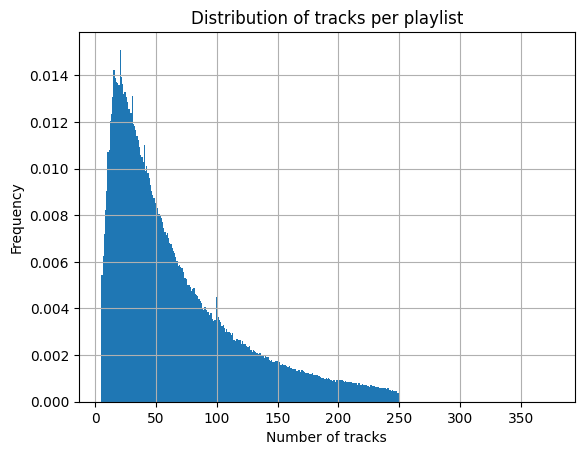

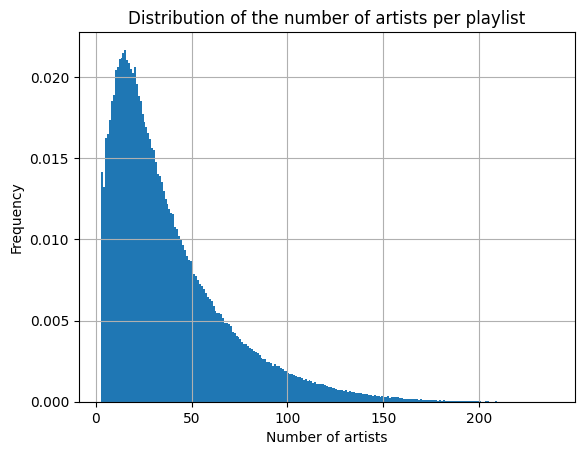

In [18]:
num_tracks = df_playlists["num_tracks"].compute()
max_tracks = num_tracks.max()
min_tracks = num_tracks.min()
num_tracks.hist(bins=(max_tracks - min_tracks + 1), density=True)
plt.xlabel("Number of tracks")
plt.ylabel("Frequency")
plt.title("Distribution of tracks per playlist")
plt.show()


# Histogram of the number of artists per playlist
num_artists = df_playlists["num_artists"].compute()
max_artists = num_artists.max()
min_artists = num_artists.min()
num_artists.hist(bins=(max_artists -min_artists), density=True )
plt.title("Distribution of the number of artists per playlist")
plt.xlabel("Number of artists")
plt.ylabel("Frequency")
plt.show()

In [19]:
# Top 10 most frequent tracks
top_tracks = (
    df_tracks.groupby(["track_id", "track_name"])
             .size()       # nombre d'apparitions
             .compute()
             .reset_index(name="count")
             .sort_values("count", ascending=False)
             .head(10)
)
# Top 10 most frequent artists
top_artists = df_tracks["artist_name"].value_counts().nlargest(10).compute()

print("Top 10 most frequent tracks:")
print(top_tracks)
print("Top 10 most frequent artists:")
print(top_artists)

Top 10 most frequent tracks:
                       track_id                           track_name  count
1680379  7KXjTSCq5nL1LoYtL7XAwS                              HUMBLE.  46574
1605700  1xznGGDReH1oQq0xzbwXa3                            One Dance  43447
222493   7yyRTcZmCiyzzJlNzGC9Ol          Broccoli (feat. Lil Yachty)  41309
1607665  7BKLCZ1jbUBVqRi2FVlTVw                               Closer  41079
147942   3a1lNhkSLSkpJE4MSHpDu9                      Congratulations  39987
1752943  5hTpBe8h35rJ67eAWHQsJx                             Caroline  35202
1313626  2EEeOnHehOozLq4aS0n6SL              iSpy (feat. Lil Yachty)  35138
1168089  4Km5HrUvYTaSUfiSGPJeQR  Bad and Boujee (feat. Lil Uzi Vert)  34999
222287   7GX5flRQZVHRAGd6B4TmDO                        XO TOUR Llif3  34922
1605368  152lZdxL1OR0ZMW6KquMif                             Location  34657
Top 10 most frequent artists:
artist_name
Drake             847160
Kanye West        413297
Kendrick Lamar    353624
Rihanna           

In [20]:
# Descriptive statistics
stats_tracks = df_playlists["num_tracks"].describe().compute()
stats_duration = (df_playlists["duration_ms"] / 60000).describe().compute()  # minutes

print("\nPlaylists:")
print("Distribution of the number of tracks per playlist:")
print(stats_tracks.apply(sci_format))
print("\nDistribution of the total duration of playlists (minutes):")
print(stats_duration.apply(sci_format))



Playlists:
Distribution of the number of tracks per playlist:
count      1.0 × 10^6
mean      66.3 × 10^0
std       53.7 × 10^0
min        5.0 × 10^0
25%       27.0 × 10^0
50%       51.0 × 10^0
75%       94.0 × 10^0
max      376.0 × 10^0
Name: num_tracks, dtype: object

Distribution of the total duration of playlists (minutes):
count      1.0 × 10^6
mean     260.0 × 10^0
std      214.0 × 10^0
min       1.63 × 10^0
25%      105.0 × 10^0
50%      197.0 × 10^0
75%      367.0 × 10^0
max       10.6 × 10^3
Name: duration_ms, dtype: object


In [26]:
# Diversity
stats_artists = df_playlists["num_artists"].describe().compute()
stats_albums = df_playlists["num_albums"].describe().compute()

print("Diversity:")
print("Number of artists per playlist:")
print(stats_artists.apply(sci_format))
print("Number of albums per playlist:")
print(stats_albums.apply(sci_format))

Diversity:
Number of artists per playlist:
count      1.0 × 10^6
mean      38.1 × 10^0
std       30.3 × 10^0
min        3.0 × 10^0
25%       16.0 × 10^0
50%       30.0 × 10^0
75%       53.0 × 10^0
max      238.0 × 10^0
Name: num_artists, dtype: object
Number of albums per playlist:
count      1.0 × 10^6
mean      49.6 × 10^0
std       40.0 × 10^0
min        2.0 × 10^0
25%       21.0 × 10^0
50%       38.0 × 10^0
75%       69.0 × 10^0
max      244.0 × 10^0
Name: num_albums, dtype: object


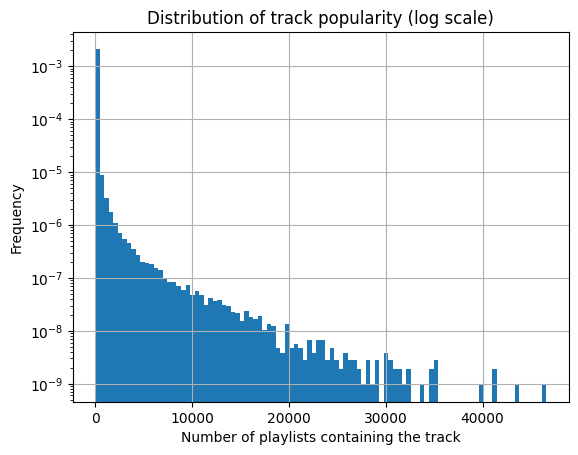

In [22]:
# Histogram of track popularity
df_tracks["track_id"].value_counts().compute().hist(bins=100,density = True,log = True)
plt.title("Distribution of track popularity (log scale)")
plt.xlabel("Number of playlists containing the track")
plt.ylabel("Frequency")
plt.show()

In [25]:
df_corr = df_playlists[["num_tracks", "num_artists", "duration_ms"]].compute()

print("\nCorrélations :")
print(df_corr.corr())


Corrélations :
             num_tracks  num_artists  duration_ms
num_tracks     1.000000     0.818381     0.980797
num_artists    0.818381     1.000000     0.798549
duration_ms    0.980797     0.798549     1.000000


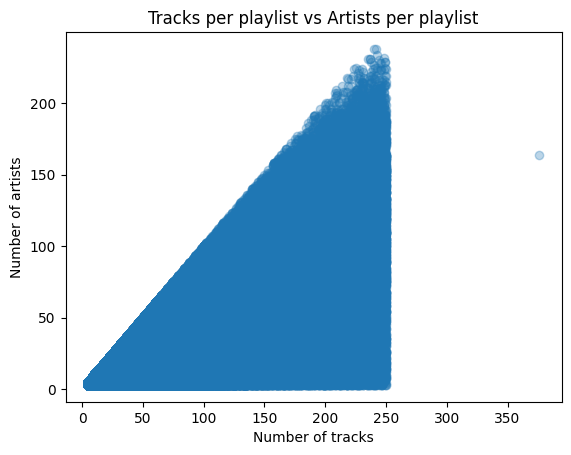

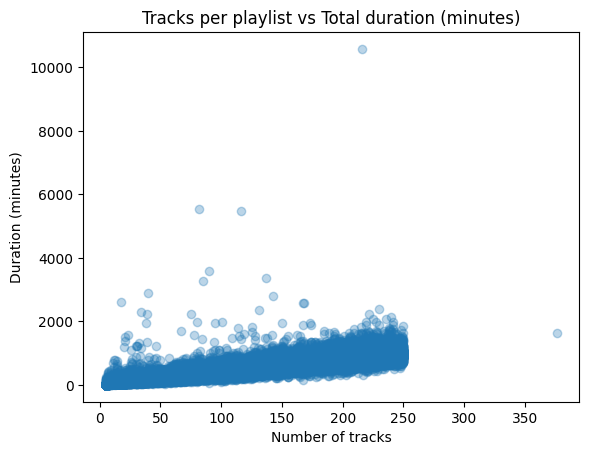

In [27]:
# Scatter plots
plt.scatter(df_corr["num_tracks"], df_corr["num_artists"], alpha=0.3)
plt.title("Tracks per playlist vs Artists per playlist")
plt.xlabel("Number of tracks")
plt.ylabel("Number of artists")
plt.show()

plt.scatter(df_corr["num_tracks"], df_corr["duration_ms"]/60000, alpha=0.3)
plt.title("Tracks per playlist vs Total duration (minutes)")
plt.xlabel("Number of tracks")
plt.ylabel("Duration (minutes)")
plt.show()

In [28]:
# Single-artist playlists
mono_artist = (df_playlists["num_artists"] == 1).sum().compute()
print("Number of single-artist playlists:", mono_artist)

# Long Playlists 
long_playlists = (df_playlists["num_tracks"] > 100).sum().compute()
print("Nombre de playlists numbers with more than 100 tracks:", long_playlists)

Number of single-artist playlists: 0
Nombre de playlists numbers with more than 100 tracks: 216482


In [29]:
# Retrieve all playlist names
names = df_playlists["name"].dropna().compute().astype(str)

# Tokenize words (all in lowercase, only letters/numbers)
all_words = []
for n in names:
    words = re.findall(r"\w+", n.lower())  # split into words
    all_words.extend(words)

# Total number of words
nb_total_words = len(all_words)

# Number of unique words
nb_unique_words = len(set(all_words))

print("Total number of words:", nb_total_words)
print("Number of unique words:", nb_unique_words)

# Top 20 most frequent words
word_counts = Counter(all_words).most_common(20)
print("Top 20 most frequent words:")
for w, c in word_counts:
    print(f"{w}: {c}")



Total number of words: 1435706
Number of unique words: 10736
Top 20 most frequent words:
music: 26499
country: 22583
summer: 21896
songs: 20568
chill: 20473
rock: 19169
playlist: 16747
good: 16637
party: 16093
the: 15779
jams: 15732
new: 15613
rap: 15217
christmas: 12640
workout: 11857
2017: 11810
my: 11763
old: 11185
s: 11124
oldies: 11038


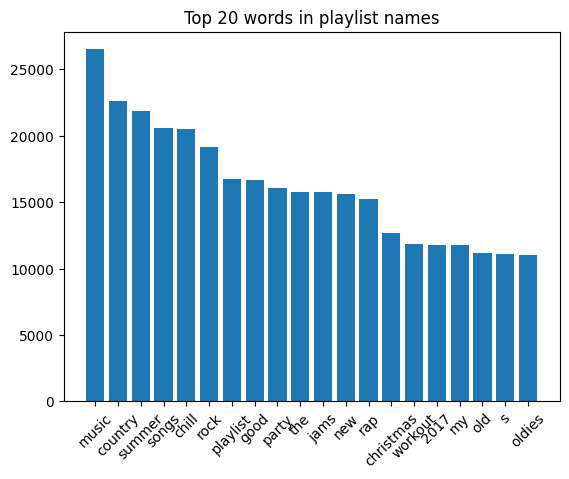

In [30]:
# Top 20 words
top_words = dict(word_counts[:20])  # top 20 words
plt.bar(top_words.keys(), top_words.values())
plt.xticks(rotation=45)
plt.title('Top 20 words in playlist names')
plt.show()

## On construit ici une df des tracks cleaned dans le sens ou les id sont débarrasé de *spotify:name:*
    - pid = playlist id

In [39]:
parquet_folder = os.path.join(sys.path[0], "data_parquet")
parquet_folder_tracks = os.path.join(sys.path[0], "data_tracks_parquet")
n = 1

all_files = glob.glob(os.path.join(parquet_folder, "*.parquet"))
df_playlists = dd.read_parquet(all_files[:n])

all_track_files = glob.glob(os.path.join(parquet_folder_tracks, "*.parquet"))
df_tracks = dd.read_parquet(all_track_files[:n])

df_tracks.head()


,pos,artist_name,track_name,duration_ms,album_name,pid,track_id,artist_id,album_id
0,0,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),226863,The Cookbook,0,0UaMYEvWZi0ZqiDOoHU3YI,2wIVse2owClT7go1WT98tk,6vV5UrXcfyQD1wu4Qo2I9K
1,1,Britney Spears,Toxic,198800,In The Zone,0,6I9VzXrHxO9rA9A5euc8Ak,26dSoYclwsYLMAKD3tpOr4,0z7pVBGOD7HCIB7S8eLkLI
2,2,Beyoncé,Crazy In Love,235933,Dangerously In Love (Alben für die Ewigkeit),0,0WqIKmW4BTrj3eJFmnCKMv,6vWDO969PvNqNYHIOW5v0m,25hVFAxTlDvXbx2X2QkUkE
3,3,Justin Timberlake,Rock Your Body,267266,Justified,0,1AWQoqb9bSvzTjaLralEkT,31TPClRtHm23RisEBtV3X7,6QPkyl04rXwTGlGlcYaRoW
4,4,Shaggy,It Wasn't Me,227600,Hot Shot,0,1lzr43nnXAijIGYnCT8M8H,5EvFsr3kj42KNv97ZEnqij,6NmFmPX56pcLBOFMhIiKvF


A priori, si $\text{track\_id}_i = \text{track\_id}_j$ :  

$$
\text{artist\_id}_i = \text{artist\_id}_j, \quad
\text{album\_id}_i = \text{album\_id}_j
$$

On peut donc chercher par `track_id` unique et créer une liste pour le `pid`. Ainsi, *list_pid* sera un vecteur de dimension $( \text{ndim} = 10 000$. Seules les composantes non nulles sont conservées et valent 0 ou 1 si elles sont présentes dans la playlist.  
Plutôt que de conserver les 0, on conserve uniquement les indices des playlists dans lesquelles la musique apparaît.  
(On pourrait éventuellement retirer les playlists avec zéro track.)

La similarité entre deux musiques peut alors se calculer de la façon suivante :  

$$
\langle a, b \rangle = \frac{|a \cap b|}{\sqrt{\text{len}(a) \cdot \text{len}(b)}} 
$$


In [74]:
df_tracks_vectors = df_tracks.groupby("track_id").agg({"pid": list})
df_tracks_vectors = df_tracks_vectors.rename(columns={"pid": "list_pid"})
df_tracks_vectors["pid_count"] = df_tracks_vectors["list_pid"].apply(len, meta=('pid_count', 'int'))
df_tracks_vectors = df_tracks_vectors.sort_values("pid_count", ascending=False)
df_tracks_vectors.head()


,list_pid,pid_count
track_id,,
1xznGGDReH1oQq0xzbwXa3,"[71, 107, 123, 161, 169, 173, 173, 175, 186, 2...",55
7KXjTSCq5nL1LoYtL7XAwS,"[28, 53, 65, 85, 95, 123, 124, 160, 164, 178, ...",52
7yyRTcZmCiyzzJlNzGC9Ol,"[28, 29, 40, 53, 95, 121, 123, 124, 178, 192, ...",50
7BKLCZ1jbUBVqRi2FVlTVw,"[35, 42, 59, 80, 93, 107, 118, 121, 161, 176, ...",46
3a1lNhkSLSkpJE4MSHpDu9,"[53, 76, 124, 143, 164, 178, 192, 194, 225, 27...",44


In [73]:
df_tracks_vectors.head()

,list_pid,pid_count,tid_num
tid_num,,,
0,"[71, 107, 123, 161, 169, 173, 173, 175, 186, 2...",55,0
1,"[28, 53, 65, 85, 95, 123, 124, 160, 164, 178, ...",52,1
2,"[28, 29, 40, 53, 95, 121, 123, 124, 178, 192, ...",50,2
3,"[35, 42, 59, 80, 93, 107, 118, 121, 161, 176, ...",46,3
4,"[53, 76, 124, 143, 164, 178, 192, 194, 225, 27...",44,4


In [75]:
track_ids = df_tracks_vectors.index.compute()
track_id_to_int = {tid: i for i, tid in enumerate(track_ids)}
int_to_track_id = {i: tid for i, tid in enumerate(track_ids)}
df_tracks_vectors = df_tracks_vectors.assign(
    tid_num = df_tracks_vectors.index.map(track_id_to_int,meta=('tid_num', 'int64'))
)
df_tracks_vectors = df_tracks_vectors.set_index("tid_num", sorted=False)


In [76]:
df_tracks_vectors.head()

,list_pid,pid_count
tid_num,,
0,"[71, 107, 123, 161, 169, 173, 173, 175, 186, 2...",55
1,"[28, 53, 65, 85, 95, 123, 124, 160, 164, 178, ...",52
2,"[28, 29, 40, 53, 95, 121, 123, 124, 178, 192, ...",50
3,"[35, 42, 59, 80, 93, 107, 118, 121, 161, 176, ...",46
4,"[53, 76, 124, 143, 164, 178, 192, 194, 225, 27...",44


In [43]:
def similar_tracks(track_id1, track_id2):
    try:
        # récupérer les listes via .loc et compute()
        list1_series = df_tracks_vectors.loc[track_id1, "list_pid"]
        list2_series = df_tracks_vectors.loc[track_id2, "list_pid"]
        
        # compute() renvoie un objet Series ou liste selon les cas
        list1 = list1_series.compute()
        list2 = list2_series.compute()

        # si c'est une Series à 1 élément, prendre la valeur
        if isinstance(list1, (pd.Series, list, tuple)):
            list1 = list1.iloc[0] if isinstance(list1, pd.Series) else list1
        if isinstance(list2, (pd.Series, list, tuple)):
            list2 = list2.iloc[0] if isinstance(list2, pd.Series) else list2

    except KeyError:
        return None

    # transformer en sets pour intersection
    set1, set2 = set(list1), set(list2)
    n_common = len(set1 & set2)
    
    if n_common == 0:
        return 0.0

    return n_common / math.sqrt(len(set1) * len(set2))

# exemple d'utilisation de similar track

In [45]:
print(f"2 musiques similaires : {similar_tracks('1xznGGDReH1oQq0xzbwXa3', '1xznGGDReH1oQq0xzbwXa3'):.3f}")
print(f"2 musiques du meme album  : {similar_tracks('35kahykNu00FPysz3C2euR', '3G6hD9B2ZHOsgf4WfNu7X1'):.3f}")
print(f"2 musiques les plus partagées  : {similar_tracks('7yyRTcZmCiyzzJlNzGC9Ol', '5dNfHmqgr128gMY2tc5CeJ'):.3f}")

2 musiques similaires : 1.000
2 musiques du meme album  : 0.000
2 musiques les plus partagées  : 0.143


In [46]:
# on passe à une représentation une playlist -> liste de tracks. De la même manière qu'avant, chaque ligne représente une playliste et la liste de ses musiques 

df_playlist_vectors = (
    df_tracks.groupby("pid")
             .agg({"track_id": list})
             .rename(columns={"track_id": "list_track_id"})
)
df_playlist_vectors["track_count"] = df_playlist_vectors["list_track_id"].apply(
    len, meta=('track_count', 'int')
)
df_playlist_vectors.head()

,list_track_id,track_count
pid,,
0,"[0UaMYEvWZi0ZqiDOoHU3YI, 6I9VzXrHxO9rA9A5euc8A...",52
1,"[2HHtWyy5CgaQbC7XSoOb0e, 1MYYt7h6amcrauCOoso3G...",39
2,"[74tqql9zP6JjF5hjkHHUXp, 4erhEGuOGQgjv3p1bccnp...",64
3,"[4WJ7UMD4i6DOPzyXU5pZSz, 1Kzxd1kkjaGX4JZz2CYsX...",126
4,"[4iCGSi1RonREsPtfEKYj5b, 5qqabIl2vWzo9ApSC317s...",17


In [47]:
nb_playlists_total = len(df_playlist_vectors)
track_counts = (
    df_tracks
    .drop_duplicates(["pid", "track_id"])  
    .groupby("track_id")["pid"]
    .nunique()
)
nb_playlists_total = df_tracks["pid"].nunique().compute()
track_counts = df_tracks.groupby("track_id")["pid"].nunique().compute()
track_counts_dict = track_counts.to_dict()
track_weights = {
    track_id: math.log((nb_playlists_total + 1) / (count + 1))  # éviter division par zéro
    for track_id, count in track_counts_dict.items()
}

In [48]:
def playlist_weight_sum(tracks, weights):
    return sum(weights.get(t, 0.0) for t in tracks)

def similar_playlists(pid1, pid2, use_weights=True):
    try:
        # récupérer les listes via .loc et compute()
        list1_series = df_playlist_vectors.loc[pid1, "list_track_id"]
        list2_series =  df_playlist_vectors.loc[pid2, "list_track_id"]
        
        # compute() renvoie un objet Series ou liste selon les cas
        list1 = list1_series.compute()
        list2 = list2_series.compute()

        # si c'est une Series à 1 élément, prendre la valeur
        if isinstance(list1, (pd.Series, list, tuple)):
            list1 = list1.iloc[0] if isinstance(list1, pd.Series) else list1
        if isinstance(list2, (pd.Series, list, tuple)):
            list2 = list2.iloc[0] if isinstance(list2, pd.Series) else list2
    except KeyError:
        return None

    set1, set2 = set(list1), set(list2)
    shared = set1 & set2
    if not shared:
        return 0.0

    if not use_weights:
        return len(shared) / math.sqrt(len(set1) * len(set2))

    shared_weight = sum(track_weights.get(t, 0.0) for t in shared)
    norm1 = math.sqrt(playlist_weight_sum(set1, track_weights))
    norm2 = math.sqrt(playlist_weight_sum(set2, track_weights))
    return shared_weight / (norm1 * norm2) if norm1 and norm2 else 0.0

In [49]:
print(f"2 playlists identiques : {similar_playlists(0, 0, use_weights=False):.3f}") # doit renvoyer 1
print(f"2 playlists random : {similar_playlists(0, 1, use_weights=False):.3f}") #contiennent toutes les deux Stays in Mexico 
print(f"2 playlists random : {similar_playlists(1, 30, use_weights=False):.3f}") 
print(f"2 playlists random : {similar_playlists(47, 99, use_weights=False):.3f}")

2 playlists identiques : 1.000
2 playlists random : 0.000
2 playlists random : 0.000
2 playlists random : 0.000


In [50]:
def similar_playlists_using_tracks(pid1, pid2, use_weights=True):
    try:
        list1 = df_playlist_vectors.loc[pid1, "list_track_id"].compute()
        list2 = df_playlist_vectors.loc[pid2, "list_track_id"].compute()

        if isinstance(list1, pd.Series):
            list1 = list1.iloc[0]
        if isinstance(list2, pd.Series):
            list2 = list2.iloc[0]
    except KeyError:
        return None
    res = 0.0
    for t1 in list1:
        # Trouver la meilleure similarité pour ce track
        sims = [similar_tracks(t1, t2) for t2 in list2]
        max_sim = max(sims) if sims else 0
        res += max_sim
    return res / len(list1)

In [51]:
print(f"2 playlists identiques : {similar_playlists_using_tracks(0, 0, use_weights=False):.3f}") # doit renvoyer 1
print(f"2 playlists random : {similar_playlists_using_tracks(0, 1, use_weights=False):.3f}") #contiennent toutes les deux Stays in Mexico 
print(f"2 playlists random : {similar_playlists_using_tracks(1, 30, use_weights=False):.3f}") 
print(f"2 playlists random : {similar_playlists_using_tracks(47, 99, use_weights=False):.3f}")

KeyboardInterrupt: 

,list_track_id,track_count
pid,,
145,"[3Vn9oCZbdI1EMO7jxdz2Rc, 6NQfUZb5VummNR8rozb8I...",46


In [77]:
tid = track_id_to_int["1xznGGDReH1oQq0xzbwXa3"]
df_tracks_vectors.loc[tid].compute()


,list_pid,pid_count
tid_num,,
0,"[71, 107, 123, 161, 169, 173, 173, 175, 186, 2...",55


,list_pid,pid_count
track_id,,
1xznGGDReH1oQq0xzbwXa3,"[71, 107, 123, 161, 169, 173, 173, 175, 186, 2...",55
7KXjTSCq5nL1LoYtL7XAwS,"[28, 53, 65, 85, 95, 123, 124, 160, 164, 178, ...",52
7yyRTcZmCiyzzJlNzGC9Ol,"[28, 29, 40, 53, 95, 121, 123, 124, 178, 192, ...",50
7BKLCZ1jbUBVqRi2FVlTVw,"[35, 42, 59, 80, 93, 107, 118, 121, 161, 176, ...",46
3a1lNhkSLSkpJE4MSHpDu9,"[53, 76, 124, 143, 164, 178, 192, 194, 225, 27...",44
